In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from scipy.stats import itemfreq
import networkx as nx
import pandas as pd

import matplotlib
import seaborn as sns
sns.set_palette('colorblind')
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['xtick.major.size'] = 9
matplotlib.rcParams['ytick.major.size'] = 9
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.size'] = 4

matplotlib.rcParams['axes.linewidth'] = 2

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['ytick.minor.width'] = 2

matplotlib.rcParams['figure.figsize'] = [10, 8]
matplotlib.rcParams['text.usetex'] = True

import random

from toysimulations import Network

import pickle

# First, ring

In [3]:
PICKLE_FILE = '../data/ring_100.pkl'


with open(PICKLE_FILE, 'rb') as f:
    result = pickle.load(f)

INS_DATA_COLUMNS = ['time', 'stoplist_len', 'stoplist_volume', 'rest_stoplist_volume',
                    'pickup_idx', 'dropoff_idx', 'insertion_type', 'pickup_enroute',
                    'dropoff_enroute']
x_range = np.array(sorted(result.keys()))
x_range[0:10]

array([0.1       , 0.5030303 , 0.90606061, 1.30909091, 1.71212121,
       2.11515152, 2.51818182, 2.92121212, 3.32424242, 3.72727273])

In [4]:
all_dfs = []

for x in x_range:
    ins_df = pd.DataFrame(result[x]['insertion_data'], 
                          columns = INS_DATA_COLUMNS)
    ins_df.loc[:, 'x'] = x
    # cut out transients
    ins_df = ins_df[ins_df['time'] * ins_df['x'] > 80000]
    all_dfs.append(ins_df)
    
master_ins_df = pd.concat(all_dfs)
master_ins_df.head()

,time,stoplist_len,stoplist_volume,rest_stoplist_volume,pickup_idx,dropoff_idx,insertion_type,pickup_enroute,dropoff_enroute,x
1569,800495.217182,1,0,0,1,1,3,False,False,0.1
1570,800689.478941,1,0,0,1,1,3,False,False,0.1
1571,801117.566710,1,0,0,1,1,3,False,False,0.1
1572,802327.077053,1,0,0,1,1,3,False,False,0.1
1573,802824.154178,1,0,0,1,1,3,False,False,0.1


In [5]:
stoplist_lens = []
vol_rests = []
vol_totals = []

for slen in range(1, max(master_ins_df['stoplist_len'])):
    sel = master_ins_df[master_ins_df['stoplist_len'] == slen]
    stoplist_lens.append(slen)
    vol_rests.append(sel['rest_stoplist_volume'].mean())
    vol_totals.append(sel['stoplist_volume'].mean())

## Analytics

In [6]:
def delta_v(v):
    if v < 0.5:
        return v**2/3 -v/2+1/4
    else:
        return (1/v - 1)*(-2*v**2/3+v-1/4)
    
def fancy_v_for_n_arr(n_max):
    n = 1
    v_arr = [0]
    
    while n < n_max:
        v = v_arr[-1]
        dv = delta_v(v)
        v_arr.append(v+dv)
        
        n += 1
    return v_arr

from functools import lru_cache

@lru_cache(maxsize=1000)
def fancy_v_for_n(n):
    if n == 0:
        return 0
    else:
        v_prev = fancy_v_for_n(n-1)
        if v_prev <=0.5:
            return v_prev/2 + v_prev**2/3 + 1/4
        else:
            return -1/(4*v_prev) + 5/4 -2*v_prev/3 + 2*v_prev**2/3

/home/dmanik/toy-ridesharing/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


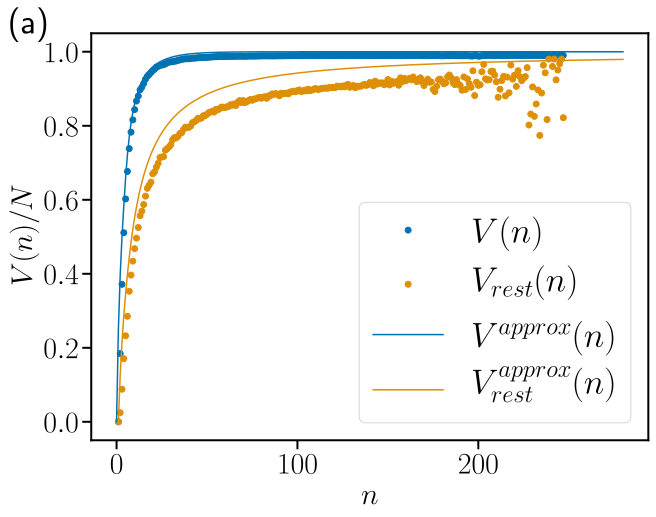

In [7]:
nmax = 280

fig, ax = plt.subplots(figsize=(10, 7.5))

ax.plot(stoplist_lens, np.array(vol_totals)/101, 'o', label=r"$V(n)$")
ax.plot(stoplist_lens, np.array(vol_rests)/101, 'o', label=r"$V_{rest}(n)$")

ax.set_prop_cycle(None)

n_range = np.arange(0, nmax+1)
ax.plot(n_range, [fancy_v_for_n(i) for i in n_range], '-', label=r"$V^{approx}(n)$")
ax.plot(n_range, [ sum(fancy_v_for_n(j) for j in range(i))/i for i in n_range], '-', label=r"$V^{approx}_{rest}(n)$")

ax.legend(fontsize=35)
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$V(n)/N$')

ax.text(-0.15, 1, '(a)', fontsize=35, transform=ax.transAxes)
fig.savefig('vol_vs_n_ring.pdf', bbox_inches='tight')

# Now star

In [8]:
PICKLE_FILE_STAR = '../data/star_100.pkl'

with open(PICKLE_FILE_STAR, 'rb') as f:
    result_star = pickle.load(f)

x_range_star = np.array(sorted(result_star.keys()))
x_range_star[0:10]

array([0.1       , 0.5030303 , 0.90606061, 1.30909091, 1.71212121,
       2.11515152, 2.51818182, 2.92121212, 3.32424242, 3.72727273])

In [9]:
all_dfs_star = []

for x in x_range_star:
    ins_df = pd.DataFrame(result_star[x]['insertion_data'], 
                          columns = INS_DATA_COLUMNS)
    ins_df.loc[:, 'x'] = x
    # cut out transients
    ins_df = ins_df[ins_df['time'] * ins_df['x'] > 6000]
    all_dfs_star.append(ins_df)
    
master_ins_df_star = pd.concat(all_dfs_star)
master_ins_df_star.head()

,time,stoplist_len,stoplist_volume,rest_stoplist_volume,pickup_idx,dropoff_idx,insertion_type,pickup_enroute,dropoff_enroute,x
1523,60114.345184,1,0,0,1,1,3,False,False,0.1
1524,60125.787733,1,0,0,1,1,3,False,False,0.1
1525,60219.595484,1,0,0,1,1,3,False,False,0.1
1526,60230.444160,1,0,0,1,1,3,False,False,0.1
1527,60242.240965,1,0,0,1,1,3,False,False,0.1


In [10]:
stoplist_lens_star = []
vol_rests_star = []
vol_totals_star = []

for slen in range(1, max(master_ins_df_star['stoplist_len'])):
    sel = master_ins_df_star[master_ins_df_star['stoplist_len'] == slen]
    stoplist_lens_star.append(slen)
    vol_rests_star.append(sel['rest_stoplist_volume'].mean())
    vol_totals_star.append(sel['stoplist_volume'].mean())

In [11]:
v_star_for_n = lambda n: (1-(1-1/101)**n)

/home/dmanik/toy-ridesharing/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


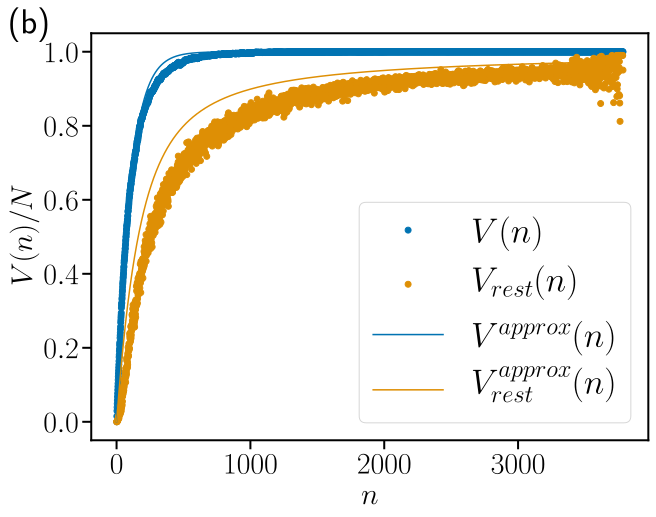

In [12]:
fig, ax = plt.subplots(figsize=(10, 7.5))

ax.plot(stoplist_lens_star, np.array(vol_totals_star)/101, 'o', label=r"$V(n)$")
ax.plot(stoplist_lens_star, np.array(vol_rests_star)/101, 'o', label=r"$V_{rest}(n)$")

ax.set_prop_cycle(None)

nmax=3500
n_range = np.arange(0, nmax+1)
ax.plot(n_range, [v_star_for_n(i) for i in n_range], '-', label=r"$V^{approx}(n)$")
ax.plot(n_range, [ sum(v_star_for_n(j) for j in range(i))/i for i in n_range], '-', label=r"$V^{approx}_{rest}(n)$")

ax.legend(fontsize=35)
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$V(n)/N$')

ax.text(-0.15, 1, '(b)', fontsize=35, transform=ax.transAxes)
fig.savefig('vol_vs_n_star.pdf', bbox_inches='tight')

## Show that $\alpha$ exists

/home/dmanik/toy-ridesharing/venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/home/dmanik/toy-ridesharing/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


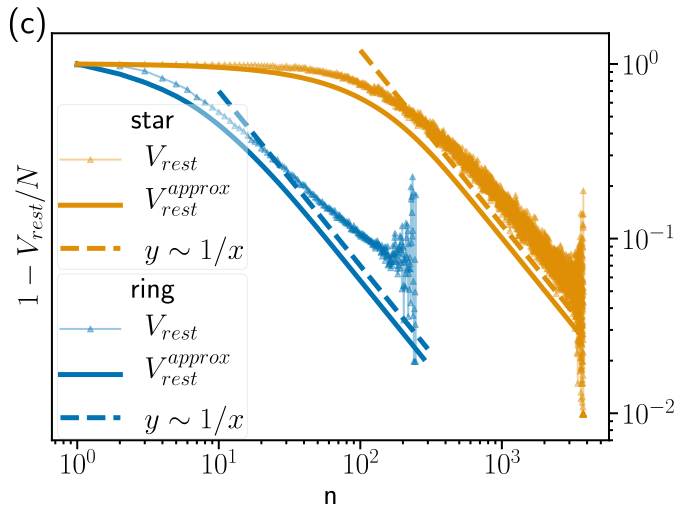

In [13]:
fig, ax = plt.subplots(figsize=(10, 7.5))
ax.set_xscale('log')
ax.set_ylim(0.007,1.5)
ax.set_yscale('log')
# ring
nmax = 280
# actual v_rest
v_ring, = ax.plot(stoplist_lens, 1-np.array(vol_rests)/101, 'o-', marker='^', alpha=0.4, linewidth=2)
v_star, = ax.plot(stoplist_lens_star, 1-np.array(vol_rests_star)/101, 'o-', marker='^', alpha=0.4, linewidth=2)

# log line
ax.set_prop_cycle(None)
log_ring, = ax.plot(np.logspace(1, np.log10(300), 100), 7/np.logspace(1, np.log10(300), 100), '--', linewidth=5)
log_star, = ax.plot(np.logspace(np.log10(100), np.log10(3500), 100), 120/np.logspace(np.log10(100), np.log10(3500), 100), '--', linewidth=5)

# analytical v_rest
ax.set_prop_cycle(None)
n_range = np.arange(0, nmax+1)
ax.set_prop_cycle(None)
v_ana_ring, = ax.plot(n_range, [1-sum(fancy_v_for_n(j) for j in range(i))/i for i in n_range], '-', label='ring', linewidth=5)
nmax=3500
n_range = np.arange(0, nmax+1)
v_ana_star, = ax.plot(n_range, [1-sum(v_star_for_n(j) for j in range(i))/i for i in n_range], '-', label='star', linewidth=5)



#ax.set_title(r"$V_{rest}$ ($\blacktriangle$), $V_{rest}^{approx}$ ($-$), $y \sim 1/x$ (- - -)", fontsize=33, pad=20)
ax.text(-0.08, 1, '(c)', fontsize=35, transform=ax.transAxes)

ax.set_xlabel("n")
ax.set_ylabel(r"$1-V_{rest}/N$")
ax.yaxis.tick_right()

# LEGEND(S)
#from matplotlib.legend_handler import HandlerTuple
#leg2 = ax.legend([(v_ring, v_star)], ['goupdata'], numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper left')
#leg1 = ax.legend(loc='lower left')
#ax.add_artist(leg2)

leg_ring = ax.legend([v_ring, v_ana_ring, log_ring], [r'$V_{rest}$', r'$V_{rest}^{approx}$', r'$y \sim 1/x$'], title = 'ring', fontsize= 30, loc=[0.01,0.004], frameon=True, borderpad=0.1, framealpha=0.4)
leg_star = ax.legend([v_star, v_ana_star, log_star], [r'$V_{rest}$', r'$V_{rest}^{approx}$', r'$y \sim 1/x$'], title = 'star', fontsize= 30, loc=[0.01,0.42], frameon=True, borderpad=0.1, framealpha=0.4)
ax.add_artist(leg_ring)

fig.savefig("demonstration_v_rest_asymptote.pdf", bbox_inches='tight')